In [89]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
import os
import argparse
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\rfgla\Documents\Ray\ffmpeg-master-latest-win64-gpl\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"
import torch
import pytorch_lightning as pl
from torchvision.io import read_video, read_video_timestamps
import sys
sys.path.append(r'C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\VideoGPT-master')
from videogpt import download, VQVAE, VideoGPT
from videogpt.data import VideoData
from videogpt.data import preprocess
from convolutional_classifier import Classifier as ConvolutionalClassifier
from transformer_classifier import Classifier as TransformerClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [94]:
# Create arg parser
vqvae_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\VideoGPT-master\lightning_logs\version_23\checkpoints\epoch=60-step=188489.ckpt"
data_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\data\gesture_sorted_data"
# Config for convolutional classifier
""" 
config = {
        "--batch_size": 1,
        "--vqvae": vqvae_path,
        "--kernel_size": 3,
        "--out_channels": 3,
        "--n_classes": 8,
        "--lr": 8e-4,
        "--gpus": 1,
        "--data_path": data_path,
    }
"""

# Config for transformer classifier
config = {
        "--batch_size": 32,
        "--vqvae": vqvae_path,
        "--n_heads": 2,
        "--dim_feedforward": 512,
        "--dropout": 0.2,
        "--n_layers": 2,
        "--lr": 7e-4,
        "--gpus": 1,
        "--data_path": data_path,
    }

parser = argparse.ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser.add_argument('--data_path', type=str, default='/home/wilson/data/datasets/bair.hdf5')
parser.add_argument('--sequence_length', type=int, default=16)
parser.add_argument('--resolution', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--num_workers', type=int, default=8)
parser = TransformerClassifier.add_model_specific_args(parser)
config_args = []
for key in config.keys():
        config_args.append(key)
        config_args.append(str(config[key]))
args = parser.parse_args(config_args)

In [95]:
# Create data loader
data = VideoData(args)
test_loader = data.test_dataloader()
args.n_classes = data.n_classes

In [96]:
# Load classifier from checkpoint
classifier_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\transformer_classifier\checkpoint_24.ckpt"
device = torch.device('cuda')
model = TransformerClassifier(args)
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=args.lr)

checkpoint = torch.load(classifier_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.to(device)
model.eval()

Classifier(
  (vqvae): VQVAE(
    (encoder): Encoder(
      (convs): ModuleList(
        (0): SamePadConv3d(
          (conv): Conv3d(3, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (1): SamePadConv3d(
          (conv): Conv3d(240, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
      )
      (conv_last): SamePadConv3d(
        (conv): Conv3d(240, 240, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      )
      (res_stack): Sequential(
        (0): AttentionResidualBlock(
          (block): Sequential(
            (0): BatchNorm3d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): SamePadConv3d(
              (conv): Conv3d(240, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
            )
            (3): BatchNorm3d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): SamePadConv3d(
              (conv): Conv3d(120, 240, kernel_size=(1, 1

In [97]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    # n must not be 0
    for i in range(0, len(lst), n):
        if i + n >= len(lst):
            yield lst[-n:]
        else:
            yield lst[i:i + n]

In [98]:
def chunks_by_overlap(lst, overlap, n):
    for i in range(0, len(lst) - n + 1, overlap):
        if i + n >= len(lst):
            yield lst[-n:], [len(lst)-n, len(lst)]
        else:
            yield lst[i:i + n], [i, i + n]

In [99]:
# Go through test folder videos
groups = ["EFL", "EFR", "SAL", "SAR", "SFE", "SFL", "SFR", "STL", "STR"]
correct = 0
count = 0
TP = [0 for _ in groups]
FN = [0 for _ in groups]
FP = [0 for _ in groups]
corrects = [0 for _ in groups]
all_counts = [0 for _ in groups]
all_pred_probs = []
all_labels = []

confusion_matrix = np.zeros([args.n_classes, args.n_classes])
for this_group in os.listdir(os.path.join(data_path, 'test')):
    group_path = os.path.join(data_path, 'test', this_group)
    if not os.path.isdir(group_path):
        continue
    gt_label = groups.index(this_group)
    for this_video in os.listdir(group_path):
        if not os.path.splitext(this_video)[1] == '.mp4':
            continue
        video_filename = os.path.join(group_path, this_video)
        resolution, sequence_length = model.args.resolution, 16
        pts = read_video_timestamps(video_filename, pts_unit='sec')[0]
        video = read_video(video_filename, pts_unit='sec', start_pts=pts[0])[0]

        overlap_size = 4  # number of frames for clips to overlap
        n_clips = video.shape[0] // sequence_length + 1

        # Get clips of certain overlap
        clips = chunks_by_overlap(video, overlap_size, sequence_length)

        # Get the minimal number of clips that covers the entire video
        # clips = chunks(video, sequence_length)

        pred_labels = []  # store predicted labels for each clip
        pred_probs = []  # store predicted probabilities in the case of a tie
        for video_clip, bounds in clips:
            video_clip = preprocess(video_clip, resolution, sequence_length).unsqueeze(0).to(device)
            with torch.no_grad():
                predictions = model(video_clip)
                pred_probs.append(predictions)
                pred_labels.append(predictions.argmax(axis=1))

        labels, counts = np.unique(torch.asarray(pred_labels).cpu().numpy(), return_counts=True)
        pred_probs = np.array([i.cpu().numpy() for i in pred_probs])
        best_label = None
        best_count = 0
        for this_label in labels:
            this_count = counts[np.where(labels == this_label)][0]
            take_this_label = False
            if best_label is None:
                take_this_label = True
            else:
                if this_count > best_count:
                    take_this_label = True
                elif this_count == best_count:
                    mean_probs = np.mean(pred_probs, axis=0)[0]
                    if mean_probs[this_label] > mean_probs[best_label]:
                        take_this_label = True
            if take_this_label:
                best_label = this_label
                best_count = this_count

        result = best_label == gt_label
        all_counts[gt_label] += 1
        if result:
            TP[best_label] += 1
            corrects[best_label] += 1
        else:
            FN[gt_label] += 1
            FP[best_label] += 1
        correct += result.sum().item()
        count += 1
        confusion_matrix[gt_label][best_label] += 1

        all_pred_probs.append(np.mean(pred_probs, axis=0)[0])
        all_labels.append(gt_label)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
(200, 9)


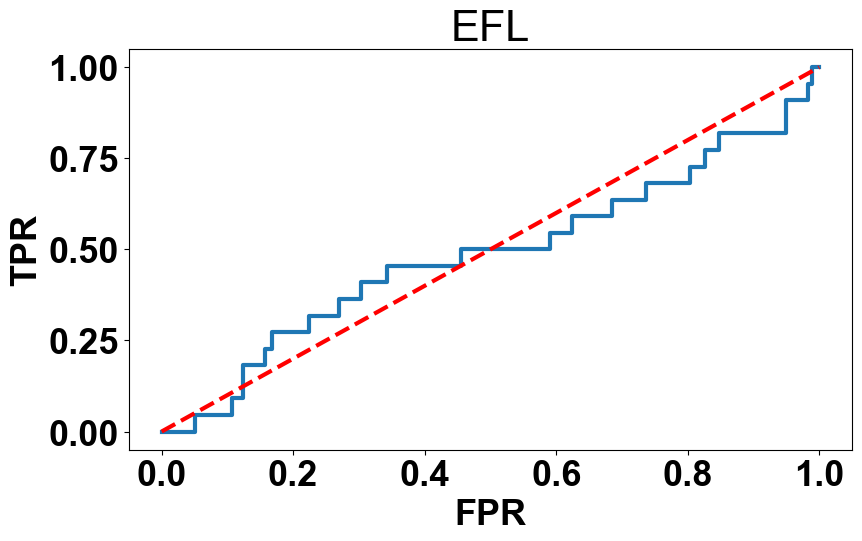

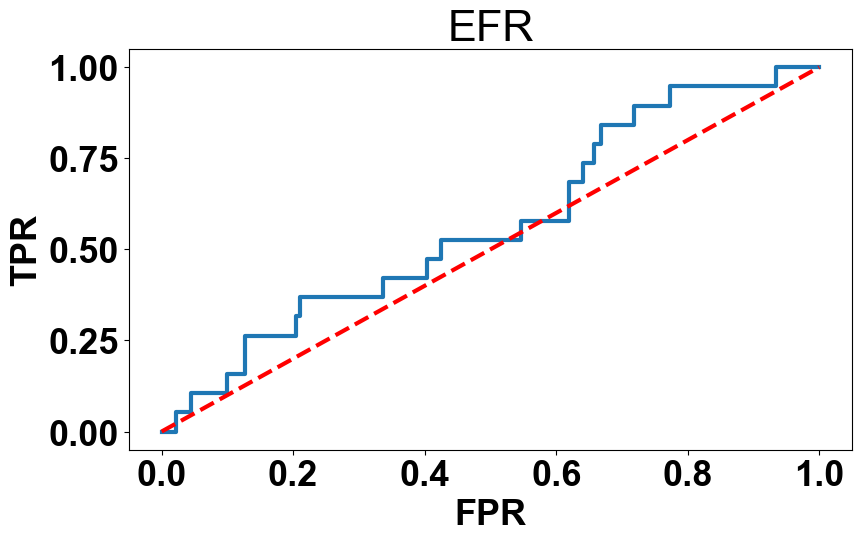

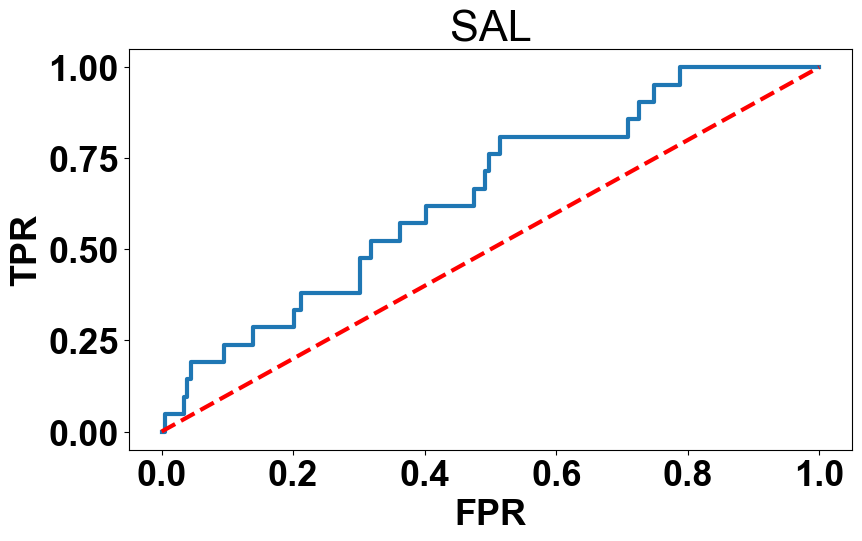

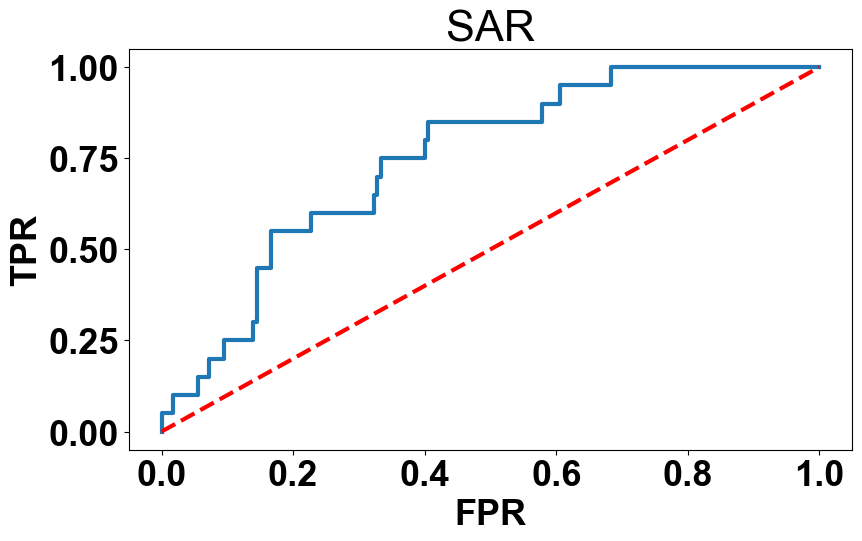

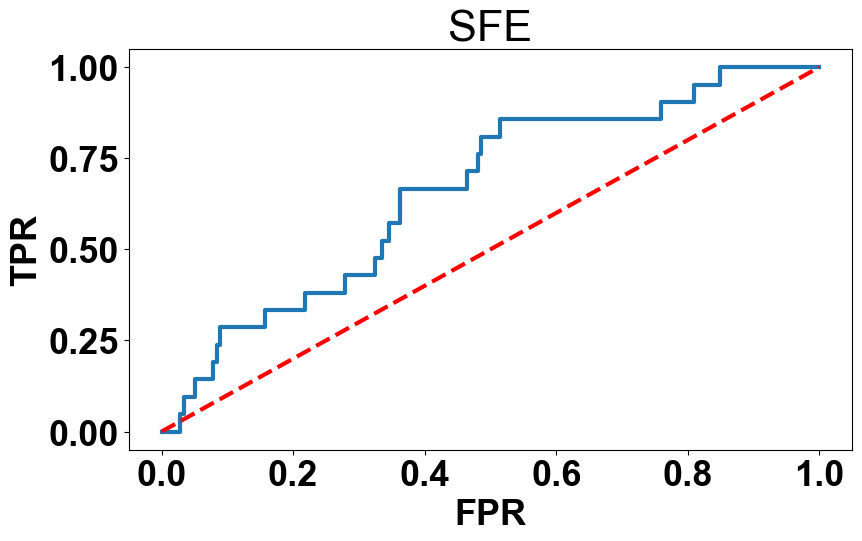

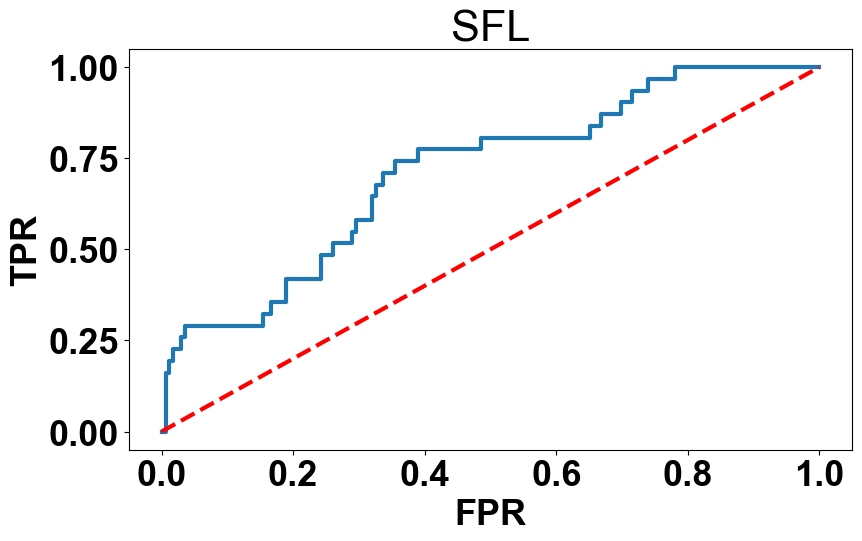

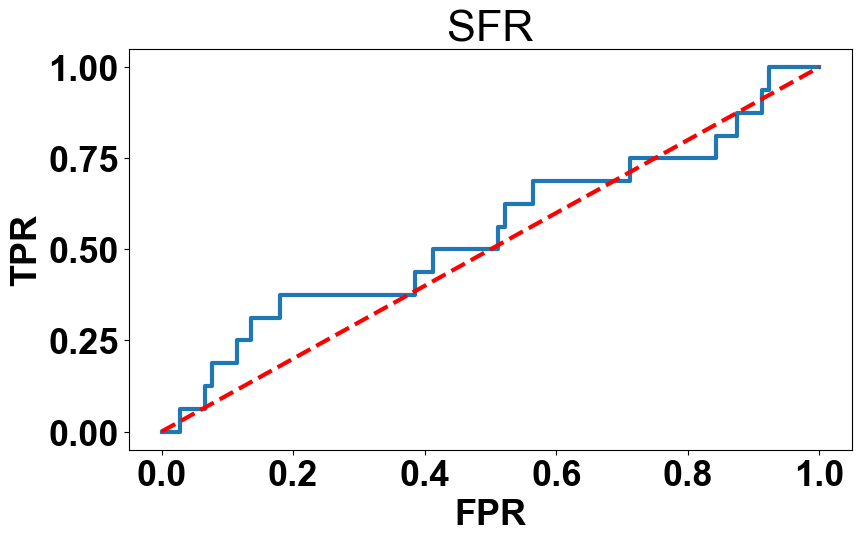

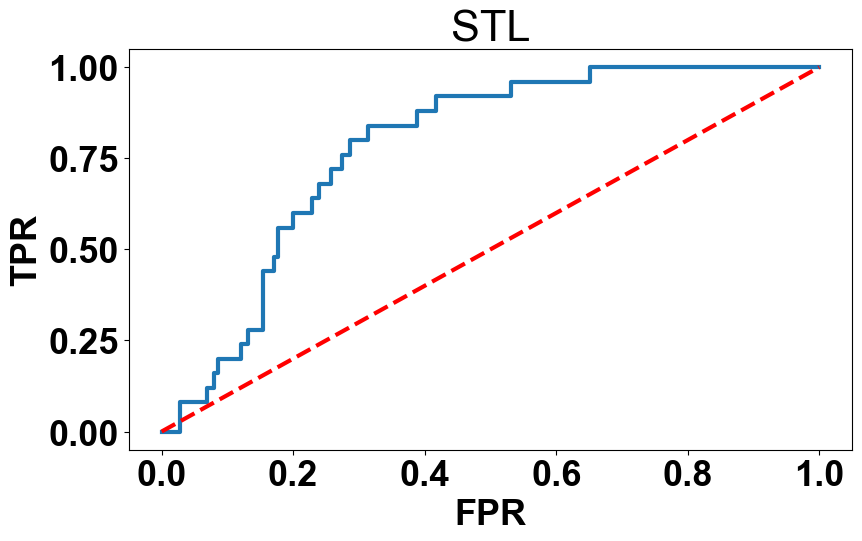

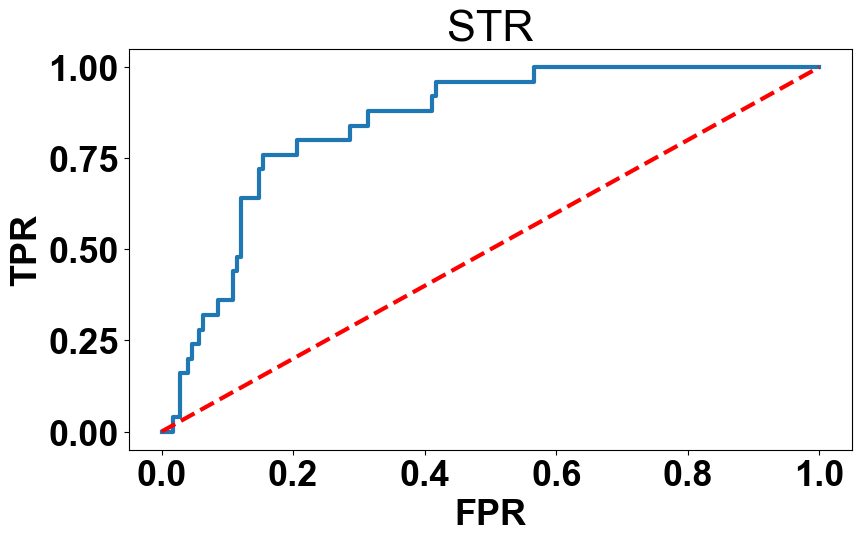

[0.4859550561797753, 0.5696423378889212, 0.6472466081404629, 0.7486111111111111, 0.6613461026868848, 0.7115861805688108, 0.546195652173913, 0.7810285714285714, 0.8457142857142856]
0.666369545099193
0.11098432034779034


In [100]:
plt.rcParams['font.size'] = 26
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 26
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['font.family'] = 'arial'
all_pred_probs = np.asarray(all_pred_probs)
print(all_labels)
aucs = []
print(all_pred_probs.shape)
ideal_line = np.linspace(0, 1, 10)
for g, this_group in enumerate(groups):
    class_pred_probs = all_pred_probs[:, g]
    binary_labels = np.where(np.array(all_labels) == g, 1, 0)
    fpr, tpr, thresholds = roc_curve(binary_labels, class_pred_probs)
    aucs.append(roc_auc_score(binary_labels, class_pred_probs))
    fig, ax = plt.subplots(1,1)
    ax.plot(fpr, tpr, lw=3)
    ax.plot(ideal_line, ideal_line, c='r', linestyle='--', lw=3)
    plt.title(this_group)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.savefig(f"roc_curve_{this_group}.pdf")
    plt.tight_layout()
    plt.show()
print(aucs)
print(np.mean(aucs))
print(np.std(aucs))

In [102]:
accuracy = correct / count
accuracies = [this_correct / all_counts[t] for t, this_correct in enumerate(corrects)]
print(accuracy)
print(np.std(accuracies))
acc_matrix = confusion_matrix / np.nanmax(confusion_matrix, axis=0)
print(confusion_matrix)
print(acc_matrix)
F1_scores = [None for _ in groups]
for g, this_group in enumerate(groups):
    if TP[g] == 0:
        F1_scores[g] = 0
    else:
        precision = TP[g] / (TP[g] + FP[g])
        recall = TP[g] / (TP[g] + FN[g])
        F1_scores[g] = 2 * (precision * recall) / (precision + recall)
    print(f"{this_group}: {F1_scores[g]}")
for g, this_group in enumerate(groups):
    print(f"{this_group} accuracy: {accuracies[g]}")
print(np.mean(F1_scores))
print(np.std(F1_scores))

0.19
0.21391193549405724
[[ 0.  4.  7.  0.  1.  0.  0.  3.  7.]
 [ 0.  1.  9.  0.  1.  1.  1.  5.  1.]
 [ 0.  2. 15.  0.  2.  0.  1.  1.  0.]
 [ 0.  0. 14.  2.  2.  0.  1.  1.  0.]
 [ 0.  0. 17.  0.  3.  0.  1.  0.  0.]
 [ 0.  2. 22.  0.  1.  0.  5.  1.  0.]
 [ 0.  1. 10.  0.  2.  0.  2.  1.  0.]
 [ 0.  0. 11.  0.  1.  0.  0.  6.  7.]
 [ 0.  1.  6.  0.  1.  0.  0.  8.  9.]]
[[       nan 1.         0.31818182 0.         0.33333333 0.
  0.         0.375      0.77777778]
 [       nan 0.25       0.40909091 0.         0.33333333 1.
  0.2        0.625      0.11111111]
 [       nan 0.5        0.68181818 0.         0.66666667 0.
  0.2        0.125      0.        ]
 [       nan 0.         0.63636364 1.         0.66666667 0.
  0.2        0.125      0.        ]
 [       nan 0.         0.77272727 0.         1.         0.
  0.2        0.         0.        ]
 [       nan 0.5        1.         0.         0.33333333 0.
  1.         0.125      0.        ]
 [       nan 0.25       0.45454545 0.         0

In [79]:
def plot_confusion_matrix(cf_matrix, classes):
    # Create a confusion matrix plot from the matrix of confusion values
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(12, 7))
    cmap0 = LinearSegmentedColormap.from_list('', ['white', *plt.cm.Blues(np.arange(255))])
    sns.heatmap(df_cm, annot=True, cmap=cmap0, vmin=0)
    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.savefig('output.png')
    # plt.plot(cf_matrix)
    return True

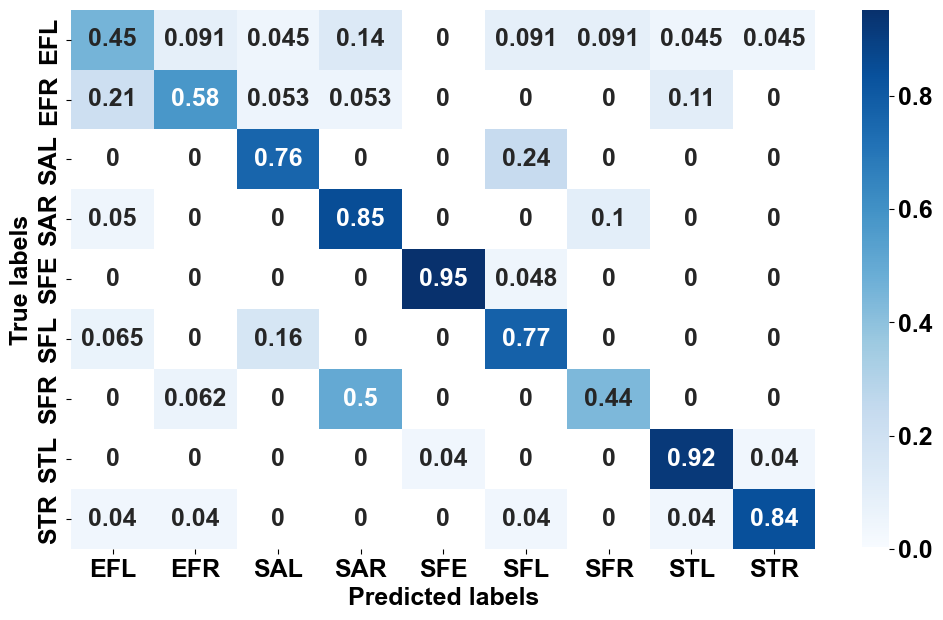

In [80]:
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['font.family'] = 'arial'
groups = ["EFL", "EFR", "SAL", "SAR", "SFE", "SFL", "SFR", "STL", "STR"]
fig = plot_confusion_matrix(confusion_matrix, groups)